This notebook demonstrates a simple Agentic RAG workflow that uses Elasticsearch as the vector store and LangChain for orchestration. It accompanies the article "Developing Adaptive Retrieval Workflows Using Elasticsearch and LangChain" and showcases the core ideas discussed there. For a deeper explanation, please refer to the article.

### Prerequisites:

This AgenticRAG example uses GPT-4.1 via AzureChatOpenAI, which requires certain environment variables to be configured.
You can substitute any other LLM if preferred.

You will be asked to set up the following environment variables:
- AZURE_OPENAI_ENDPOINT
- AZURE_OPENAI_KEY
- AZURE_OPENAI_DEPLOYMENT
- AZURE_OPENAI_API_VERSION
- ES_ENDPOINT
- ES_API_KEY

In [4]:
!pip3 install langchain langgraph langchain-openai langchain-elasticsearch langchain-community datasets python-dotenv loguru elasticsearch "pydantic>=2.0" duckduckgo-search

In [64]:
import time
import getpass

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableSequence
from langchain_openai import AzureChatOpenAI
from langchain.chains import LLMChain, SequentialChain
from datasets import load_dataset
from langchain.schema import Document
from langchain_elasticsearch import ElasticsearchStore, SparseVectorStrategy
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, List, Literal
from loguru import logger
from pydantic import BaseModel, Field
from elasticsearch import Elasticsearch, NotFoundError, BadRequestError
from IPython.display import Image

### Set the environment variables

In [32]:
ES_ENDPOINT = getpass.getpass("Enter Elastic Endpoint:  ")
ES_API_KEY = getpass.getpass("Enter Elastic API Key:  ")

In [33]:
AZURE_OPENAI_ENDPOINT = getpass.getpass("Enter Azure OpenAI Endpoint:  ")
AZURE_OPENAI_KEY = getpass.getpass("Enter Azure OpenAI Key:  ")
AZURE_OPENAI_DEPLOYMENT = getpass.getpass("Enter Azure OpenAI Deployment:  ")
AZURE_OPENAI_API_VERSION = getpass.getpass("Enter Azure OpenAI API Version:  ")

### Install ELSER

In [44]:
es = Elasticsearch(hosts=[ES_ENDPOINT], api_key=ES_API_KEY, request_timeout=3600)

In [37]:
def install_elser(es: Elasticsearch, model_id: str):
    try:
        es.ml.get_trained_models(model_id=model_id)
    except NotFoundError:
        logger.info(f'"{model_id}" not found. Installing...')
        es.ml.put_trained_model(
            model_id=model_id, input={"field_names": ["text_field"]}
        )

    while True:
        status = es.ml.get_trained_models(
            model_id=model_id, include="definition_status"
        )
        if status["trained_model_configs"][0]["fully_defined"]:
            break
        time.sleep(1)

    stats = es.ml.get_trained_models_stats(model_id=model_id)
    allocation_state = (
        stats["trained_model_stats"][0]
        .get("deployment_stats", {})
        .get("allocation_status", {})
        .get("state")
    )
    if allocation_state != "fully_allocated":
        try:
            es.ml.start_trained_model_deployment(
                model_id=model_id, wait_for="fully_allocated"
            )
        except BadRequestError:
            pass

    logger.info(f'"{model_id}" model is ready')

In [38]:
install_elser(es, ".elser_model_2")

2025-11-06 10:05:52.472 | INFO     | __main__:install_elser:22 - ".elser_model_2" model is ready


### Define your LLM

In [58]:
llm = AzureChatOpenAI(
    azure_deployment=AZURE_OPENAI_DEPLOYMENT,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_OPENAI_API_VERSION,
    api_key=AZURE_OPENAI_KEY,
)

#### Load AG news dataset

In [40]:
dataset = load_dataset("ag_news", split="train[:1000]")
docs = [
    Document(page_content=sample["text"], metadata={"category": sample["label"]})
    for sample in dataset
]

#### Add documents to Elasticsearch vector store

In [41]:
index_name = "news_docs"
elastic_vectorstore = ElasticsearchStore.from_documents(
    docs,
    es_url=ES_ENDPOINT,
    es_api_key=ES_API_KEY,
    es_params={"request_timeout": 60, "max_retries": 3, "retry_on_timeout": True},
    index_name=index_name,
    strategy=SparseVectorStrategy(model_id=".elser_model_2"),
)

elastic_vectorstore.client.indices.refresh(index=index_name)

ObjectApiResponse({'_shards': {'total': 2, 'successful': 2, 'failed': 0}})

### Define your data retrieval options

In [46]:
def vectorstore_retriever(query, k=5):
    results = elastic_vectorstore.similarity_search_with_score(query, k=k)
    docs = [doc for doc, score in results]
    related_docs = "\n".join([d.page_content for d in docs])
    return related_docs


duckduckgo = DuckDuckGoSearchRun(
    description="A custom DuckDuckGo search tool for finding latest news stories.",
    verbose=True,
)


def websearch_retriever(query):
    results = duckduckgo.run(f"{query}")
    return results


def composite_retriever(query):
    related_docs = vectorstore_retriever(query)
    related_docs += websearch_retriever(query)
    return related_docs

### Define your LLM Chains

In [59]:
class RouteQuery(BaseModel):
    datasource: Literal["vectorstore", "websearch", "composite"] = Field(
        ...,
        description="Choose to route the query to web search, vectorstore or composite.",
    )


router_prompt = ChatPromptTemplate.from_template(
    """You are an assistant that decides the best data source for questions based on news articles.
Choose one of the following options:
- 'vectorstore': for general, background, or historical news articles.
- 'websearch': for recent discoveries, 'latest', 'current', or '2025' type queries.
- 'composite': when the question needs both historical and current knowledge on news articles.

Question: {query}

Return one word: 'vectorstore', 'websearch', or 'composite'.
"""
)
router_structured = llm.with_structured_output(RouteQuery)
router_chain: RunnableSequence = router_prompt | router_structured


class GradeRetrievedDocs(BaseModel):
    binary_score: bool = Field(
        description="True if retrieved documents match the query intent, False otherwise."
    )


grade_retrieved_docs_prompt = ChatPromptTemplate.from_template(
    """
You are an evaluator that determines whether the retrieved documents are relevant to the given user query.

Instructions:
- Compare the intent and information need of the query against the retrieved documents.
- Answer only 'True' or 'False'.
- 'True' means the retrieved documents align with the query’s intent and can likely answer it.
- 'False' means the retrieved documents do not address the main topic or intent of the query.

Return only one word: 'True' or 'False'.

Query:
{query}

Retrieved Documents:
{docs}
"""
)

retrieved_docs_structured = llm.with_structured_output(GradeRetrievedDocs)
grade_docs_chain: RunnableSequence = (
    grade_retrieved_docs_prompt | retrieved_docs_structured
)


class RewrittenQuery(BaseModel):
    query: str


rewrite_query_prompt = ChatPromptTemplate.from_template(
    """
The grader returned that the retrieved documents do not answer the query. Reformulate the query to better capture the user's intent and retrieve relevant information. Return ONLY the rewritten query, concise and clear. Just the string i.e. the rewritten query.

Original Query:
{query}
"""
)
rewritten_query_structured = llm.with_structured_output(RewrittenQuery)
rewrite_query_chain: RunnableSequence = (
    rewrite_query_prompt | rewritten_query_structured
)

summarize_prompt = ChatPromptTemplate.from_template(
    """You are a helpful news assistant. Your task is to summarize the retrieved news articles in a concise and accurate way that directly answers the user's query.
User Query:
{query}

Retrieved Articles:
{docs}

Instructions:
- Focus on the most relevant information that answers the query.
- Do not include unrelated details.
- Present the summary in clear, coherent sentences.
- If multiple articles provide overlapping information, combine them without repetition.

Summary:"""
)
summarize_chain = LLMChain(
    llm=llm, prompt=summarize_prompt, output_parser=StrOutputParser()
)

### Start building the StateGraph

In [60]:
class RAGState(TypedDict):
    query: str
    docs: List[Document]
    router: str
    summary: str
    self_reflection: bool
    retry_count: int = 0


def router(state: RAGState):
    router = router_chain.invoke({"query": state["query"]})
    logger.info(f"Router selected the datasource: {router.datasource}")
    logger.info(f"User query: {state['query']}")
    return {"router": router.datasource}


def vectorstore(state: RAGState):
    return {"docs": vectorstore_retriever(state["query"])}


def websearch(state: RAGState):
    return {"docs": websearch_retriever(state["query"])}


def composite(state: RAGState):
    return {"docs": composite_retriever(state["query"])}


def self_reflection(state: RAGState):
    evaluation = grade_docs_chain.invoke(
        {"query": state["query"], "docs": state["docs"]}
    )
    if evaluation.binary_score:
        logger.info(f"Self-reflection passed — binary_score={evaluation.binary_score}")
    else:
        logger.info(f"Self-reflection failed — binary_score={evaluation.binary_score}")

    return {
        "self_reflection": evaluation.binary_score,
    }


def query_rewriter(state: RAGState):
    retry_count = state.get("retry_count", 0) + 1
    new_query = rewrite_query_chain.invoke({"query": state["query"]})
    logger.info(f"Query rewritten: {new_query}, retry_count: {retry_count}")
    return {
        "query": new_query,
        "retry_count": retry_count,
    }


def summarize(state: RAGState):
    summary = summarize_chain.run(
        query=state["query"],
        docs=state["docs"],
    )
    return {"summary": summary}

### Build Graph with LangChain

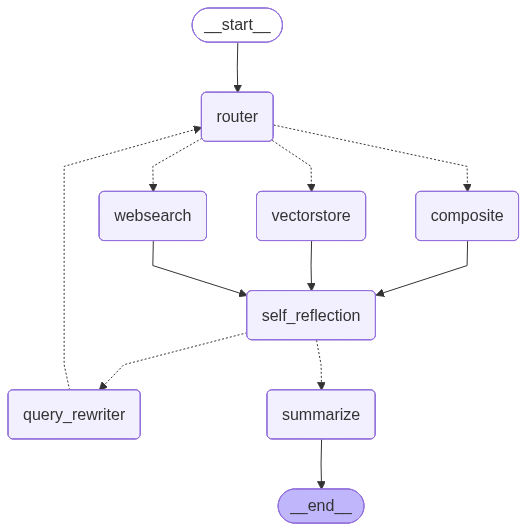

In [61]:
graph = StateGraph(RAGState)

graph.add_node("router", router)
graph.add_node("vectorstore", vectorstore)
graph.add_node("websearch", websearch)
graph.add_node("composite", composite)
graph.add_node("self_reflection", self_reflection)
graph.add_node("query_rewriter", query_rewriter)
graph.add_node("summarize", summarize)

graph.add_edge(START, "router")


def after_router(state: RAGState):
    route = state.get("router", None)
    if route == "vectorstore":
        return "vectorstore"
    elif route == "websearch":
        return "websearch"
    else:
        return "composite"


def after_self_reflection(state: RAGState):
    if state["self_reflection"]:
        return "summarize"
    return "query_rewriter"


def after_query_rewriter(state: RAGState):
    while state["retry_count"] <= 3:
        return "router"
    raise RuntimeError("Maximum retries (3) reached — evaluation failed.")


graph.add_conditional_edges(
    "router",
    after_router,
    {"vectorstore": "vectorstore", "websearch": "websearch", "composite": "composite"},
)

graph.add_edge("vectorstore", "self_reflection")
graph.add_edge("websearch", "self_reflection")
graph.add_edge("composite", "self_reflection")
graph.add_conditional_edges(
    "self_reflection",
    after_self_reflection,
    {"summarize": "summarize", "query_rewriter": "query_rewriter"},
)
graph.add_conditional_edges(
    "query_rewriter", after_query_rewriter, {"router": "router"}
)
graph.add_edge("summarize", END)
agent = graph.compile()
agent.get_graph().draw_mermaid_png(output_file_path="graph.png")
Image("graph.png")

### Start testing

In [62]:
query1 = "What are the latest AI models released this month?"
query2 = "What technological innovations are discussed in Sci/Tech news?"
query3 = "Compare a Sci/Tech article from the dataset with a current web article about AI trends."

In [63]:
result = agent.invoke({"query": query1})
logger.info(f"\nFinal Summary:\n: {result['summary']}")

2025-11-06 10:30:53.873 | INFO     | __main__:router:11 - Router selected the datasource: websearch
2025-11-06 10:30:53.874 | INFO     | __main__:router:12 - User query: What are the latest AI models released this month?


What Is The Best AI Model In September 2025? Ultimate Comparison The five most powerful AI companies have now unveiled their flagship models , creating what might be the most intense competition we've seen in artificial intelligence development. OpenAI dropped GPT-5 in early August 2025, while Anthropic released Claude Opus 4.1 just days earlier. Here's what I've learned after testing every major AI release this month : The real question isn't about keeping up with every shiny new model . It's about how to use AI tools responsibly while they rapidly evolve around us. Missed the latest AI news? From ChatGPT upgrades to Google's new tools, here are 7 big AI updates you need to know about this week. To fully meet our goals, MAI requires purpose-built models . Today, we're excited to preview the first steps to making this a reality. First, we're releasing MAI-Voice-1, our first highly expressive and natural speech generation model , which is available in Copilot Daily and Podcasts, and as 

2025-11-06 10:30:58.545 | INFO     | __main__:self_reflection:29 - Self-reflection passed — binary_score=True
2025-11-06 10:31:00.390 | INFO     | __main__:<module>:2 - 
Final Summary:
: The latest AI models released this month include OpenAI's GPT-5, launched in early August 2025, and Anthropic's Claude Opus 4.1, alongside Claude Opus 4 and Claude Sonnet 4, which feature advanced capabilities in coding and long-duration problem-solving. Additionally, MAI unveiled MAI-Voice-1, a highly expressive speech generation model, now available in Copilot applications. These releases mark significant advancements from leading AI companies.


In [54]:
result = agent.invoke({"query": query2})
logger.info(f"\nFinal Summary:\n: {result['summary']}")

2025-11-06 10:29:14.260 | INFO     | __main__:router:11 - Router selected the datasource: vectorstore
2025-11-06 10:29:14.261 | INFO     | __main__:router:12 - User query: What technological innovations are discussed in Sci/Tech news?
/Users/kirtisodhi/Library/Python/3.9/lib/python/site-packages/langchain_elasticsearch/_sync/vectorstores.py:530: ElasticsearchWarning: text_expansion is deprecated. Use sparse_vector instead.
  hits = self._store.search(
2025-11-06 10:29:14.771 | INFO     | __main__:self_reflection:29 - Self-reflection passed — binary_score=True
2025-11-06 10:29:16.247 | INFO     | __main__:<module>:2 - 
Final Summary:
: Recent Sci/Tech news highlights several technological innovations: NASA is developing a cutting-edge Linux-based supercomputer to support researchers and shuttle engineers; a company has achieved cat cloning through chromatin transfer technology; Princeton University scientists report that current technologies can be implemented immediately to stabilize g

In [56]:
result = agent.invoke({"query": query3})
logger.info(f"\nFinal Summary:\n: {result['summary']}")

2025-11-06 10:29:38.534 | INFO     | __main__:router:11 - Router selected the datasource: composite
2025-11-06 10:29:38.535 | INFO     | __main__:router:12 - User query: Compare a Sci/Tech article from the dataset with a current web article about AI trends.
/Users/kirtisodhi/Library/Python/3.9/lib/python/site-packages/langchain_elasticsearch/_sync/vectorstores.py:530: ElasticsearchWarning: text_expansion is deprecated. Use sparse_vector instead.
  hits = self._store.search(


3 days ago - In the late 2010s, graphics processing ... large-scale (commercial and academic) machine learning models' training. Specialized programming languages such as Prolog were used in early AI research, but general-purpose programming languages like Python have become predominant. The transistor density in integrated circuits has been observed to roughly double every 18 months—a trend known as Moore's ... May 1, 2025 - Models with advanced reasoning capabilities, like OpenAI o1, can already solve complex problems with logical steps that are similar to how humans think before responding to difficult questions. These capabilities will continue to be useful in fields like science, coding, math, law and medicine, allowing models to compare contracts, generate code and execute multistep workflows. 2 days ago - In any given business function, no more than 10 percent of respondents say their organizations are scaling AI agents (Exhibit 2). Looking at individual business functions, agen

2025-11-06 10:29:40.618 | INFO     | __main__:self_reflection:29 - Self-reflection passed — binary_score=True
2025-11-06 10:29:42.894 | INFO     | __main__:<module>:2 - 
Final Summary:
: The Sci/Tech article from the dataset highlights NASA's development of advanced AI for planetary rovers, aiming to make them more autonomous and capable of making mission-critical decisions independently. This reflects a trend towards specialized AI applications in science and exploration.

Compared to current web articles on AI trends, the broader industry focus is on scaling AI models and agents across various sectors, especially in IT, healthcare, and knowledge management. Recent models like OpenAI o1 showcase advanced reasoning, supporting complex tasks in coding, law, and medicine. While organizations are experimenting with AI agents, widespread deployment is still limited. The global AI market continues to grow, with North America as a leader and China rapidly adopting AI solutions.

In summary, 